<a href="https://colab.research.google.com/github/23manuel/Churn_predictor_analysis/blob/main/customer_churn_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries

import pandas as pd
import numpy as np

In [2]:
# Mounting Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Loading datasets

transactions = pd.read_csv("/content/drive/My Drive/archive(6)/transactions_data.csv", nrows = 500000)
cards = pd.read_csv("/content/drive/My Drive/archive(6)/cards_data.csv")
users = pd.read_csv("/content/drive/My Drive/archive(6)/users_data.csv")


print("transactions:")
display(transactions.head(3))
print(f"Shape: {transactions.shape}\n")

print("cards:")
display(cards.head(3))
print(f"Shape: {cards.shape}\n")

print("users:")
display(users.head(3))
print(f"Shape: {users.shape}\n")

transactions:


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN


Shape: (500000, 12)

cards:


,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No


Shape: (6146, 13)

users:


,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5


Shape: (2000, 14)



In [4]:
# Clean and preprocess

# Clean 'amount' column ($, commas, negatives)
transactions['amount'] = (
    transactions['amount']
    .replace('[\$,]', '', regex=True)
    .astype(float)
)

# Handle missing zip or errors
transactions['zip'] = transactions['zip'].fillna(0).astype(int)
transactions['errors'] = transactions['errors'].fillna('None')

# Format dates
transactions['date'] = pd.to_datetime(transactions['date'], errors='coerce')
# Specify date format to avoid UserWarning
cards['acct_open_date'] = pd.to_datetime(cards['acct_open_date'], format='%m/%Y', errors='coerce')

# Clean numeric fields in cards/users
cards['credit_limit'] = cards['credit_limit'].replace('[\$,]', '', regex=True).astype(float)
users['per_capita_income'] = users['per_capita_income'].replace('[\$,]', '', regex=True).astype(float)
users['yearly_income'] = users['yearly_income'].replace('[\$,]', '', regex=True).astype(float)
users['total_debt'] = users['total_debt'].replace('[\$,]', '', regex=True).astype(float)

# Drop client_id from transactions before merging to avoid ambiguity
transactions_cleaned = transactions.drop(columns=['client_id'])

<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:20: SyntaxWarning: invalid escape sequence '\$'
<>:21: SyntaxWarning: invalid escape sequence '\$'
<>:22: SyntaxWarning: invalid escape sequence '\$'
<>:23: SyntaxWarning: invalid escape sequence '\$'
<>:6: SyntaxWarning: invalid escape sequence '\$'
<>:20: SyntaxWarning: invalid escape sequence '\$'
<>:21: SyntaxWarning: invalid escape sequence '\$'
<>:22: SyntaxWarning: invalid escape sequence '\$'
<>:23: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipython-input-4197088674.py:6: SyntaxWarning: invalid escape sequence '\$'
  .replace('[\$,]', '', regex=True)
/tmp/ipython-input-4197088674.py:20: SyntaxWarning: invalid escape sequence '\$'
  cards['credit_limit'] = cards['credit_limit'].replace('[\$,]', '', regex=True).astype(float)
/tmp/ipython-input-4197088674.py:21: SyntaxWarning: invalid escape sequence '\$'
  users['per_capita_income'] = users['per_capita_income'].replace('[\$,]', '', regex=True).astype(float)
/tmp/ipython-i

In [5]:
print("Cleaned transactions:")
display(transactions_cleaned.head(5))
print(f"Shape: {transactions_cleaned}\n")

Cleaned transactions:


,id,date,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None
1,7475328,2010-01-01 00:02:00,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None
2,7475329,2010-01-01 00:02:00,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None
3,7475331,2010-01-01 00:05:00,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None
4,7475332,2010-01-01 00:06:00,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None


Shape:              id                date  card_id  amount           use_chip  \
0       7475327 2010-01-01 00:01:00     2972  -77.00  Swipe Transaction   
1       7475328 2010-01-01 00:02:00     4575   14.57  Swipe Transaction   
2       7475329 2010-01-01 00:02:00      102   80.00  Swipe Transaction   
3       7475331 2010-01-01 00:05:00     2860  200.00  Swipe Transaction   
4       7475332 2010-01-01 00:06:00     3915   46.41  Swipe Transaction   
...         ...                 ...      ...     ...                ...   
499995  8073843 2010-05-31 07:19:00     5825   22.43  Swipe Transaction   
499996  8073844 2010-05-31 07:19:00     4574   23.45  Swipe Transaction   
499997  8073845 2010-05-31 07:20:00     2026  -51.00  Swipe Transaction   
499998  8073847 2010-05-31 07:21:00      988  171.18  Swipe Transaction   
499999  8073848 2010-05-31 07:21:00     3043    5.55  Swipe Transaction   

        merchant_id merchant_city merchant_state    zip   mcc errors  
0             59935  

In [6]:
# Merge datasets
merged = transactions_cleaned.merge(cards, left_on='card_id', right_on='id') # No suffixes needed here for client_id
# Use default suffixes for the second merge and then clean up
merged = merged.merge(users, left_on='client_id', right_on='id')

# Drop duplicate and redundant columns
# After the merges, there will be id_x (from transactions_cleaned.id), id_y (from cards.id), and id (from users.id)
# The id from users is the join key in the second merge, so we drop the others.
drop_cols = ['id_x', 'id_y'] # Corrected: dropping id_x and id_y which are from the first merge
print("Columns before dropping:", merged.columns) # Added line to inspect columns before dropping

merged = merged.drop(columns=[c for c in drop_cols if c in merged.columns])

Columns before dropping: Index(['id_x', 'date', 'card_id', 'amount', 'use_chip', 'merchant_id',
       'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors', 'id_y',
       'client_id', 'card_brand', 'card_type', 'card_number', 'expires', 'cvv',
       'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_on_dark_web', 'id', 'current_age',
       'retirement_age', 'birth_year', 'birth_month', 'gender', 'address',
       'latitude', 'longitude', 'per_capita_income', 'yearly_income',
       'total_debt', 'credit_score', 'num_credit_cards'],
      dtype='object')


In [7]:
# Handle missing values
merged = merged.fillna({
    'merchant_city': 'Unknown',
    'merchant_state': 'Unknown',
    'use_chip': 'Unknown'
})

# Verify result
print("Clean merged dataset shape:", merged.shape)
print("\nSample:")
print(merged.head(3))

Clean merged dataset shape: (500000, 36)

Sample:
                 date  card_id  amount           use_chip  merchant_id  \
0 2010-01-01 00:01:00     2972  -77.00  Swipe Transaction        59935   
1 2010-01-01 00:02:00     4575   14.57  Swipe Transaction        67570   
2 2010-01-01 00:02:00      102   80.00  Swipe Transaction        27092   

  merchant_city merchant_state    zip   mcc errors  ...  birth_month  gender  \
0        Beulah             ND  58523  5499   None  ...            7  Female   
1    Bettendorf             IA  52722  5311   None  ...            6    Male   
2         Vista             CA  92084  4829   None  ...            4    Male   

                    address  latitude longitude  per_capita_income  \
0  594 Mountain View Street     46.80   -100.76            23679.0   
1           604 Pine Street     40.80    -91.12            18076.0   
2          2379 Forest Lane     33.18   -117.29            16894.0   

  yearly_income  total_debt  credit_score num_credi

In [8]:
# Save for modeling
path = "/content/drive/My Drive/archive(6)/" # Define the path to the directory
merged.to_csv(path + 'merged_clean_data.csv', index=False)
print("\nSaved as merged_clean_data.csv")


Saved as merged_clean_data.csv


In [9]:
# Customer summary
# Converting thousands of transactions per user into a summary. Per person not per transaction - churn

txn_counts = merged.groupby('client_id')['amount'].count().reset_index()
txn_counts = txn_counts.rename(columns={'amount': 'num_transactions'})

txn_total = merged.groupby('client_id')['amount'].sum().reset_index()
txn_total = txn_total.rename(columns={'amount': 'total_spent'})

txn_avg = merged.groupby('client_id')['amount'].mean().reset_index()
txn_avg = txn_avg.rename(columns={'amount': 'avg_transaction'})

last_txn = merged.groupby('client_id')['date'].max().reset_index()
last_txn = last_txn.rename(columns={'date': 'last_transaction'})


# Merge all tables

customer_features = txn_counts.copy()

customer_features = customer_features.merge(txn_total, on='client_id', how='left')
customer_features = customer_features.merge(txn_avg, on='client_id', how='left')
customer_features = customer_features.merge(last_txn, on='client_id', how='left')


In [10]:
# Define "today" as the last date in 'transactions'
today = merged['date'].max()
print("Reference date for churn:", today)

# Compute days (days since last transaction)
customer_features['days_since_last'] = (today - customer_features['last_transaction']).dt.days
# Define churn (90 days rule)
customer_features['churn'] = (customer_features['days_since_last'] >= 90).astype(int)

customer_features[['client_id', 'last_transaction', 'days_since_last', 'churn']].head()

Reference date for churn: 2010-05-31 07:21:00


,client_id,last_transaction,days_since_last,churn
0,0,2010-05-30 22:10:00,0,0
1,1,2010-05-30 11:39:00,0,0
2,2,2010-05-30 14:33:00,0,0
3,3,2010-05-30 14:50:00,0,0
4,4,2010-05-30 22:06:00,0,0


In [11]:
print(customer_features)
print(cards)

      client_id  num_transactions  total_spent  avg_transaction  \
0             0               472     25284.31        53.568453   
1             1               407     13612.23        33.445283   
2             2               472     13039.28        27.625593   
3             3               198      7861.80        39.706061   
4             4               648     27579.93        42.561620   
...         ...               ...          ...              ...   
1107       1993               347     23253.89        67.014092   
1108       1995               483     18272.76        37.831801   
1109       1996               356     16680.28        46.854719   
1110       1997               443     24937.93        56.293296   
1111       1998               172      3029.77        17.614942   

        last_transaction  days_since_last  churn  
0    2010-05-30 22:10:00                0      0  
1    2010-05-30 11:39:00                0      0  
2    2010-05-30 14:33:00                0 

In [12]:
# Combining customer features with user + card features
# Add up card data per customer
# Number of cards a customer has
cards_per_customer = cards.groupby('client_id').agg({
    'id': 'count',
    'credit_limit': 'sum'
}).rename(columns={
    'id': 'num_cards',
    'credit_limit': 'total_credit_limit'
})

# Merge customer features with user demographics
final_df = customer_features.merge(users, left_on='client_id', right_on='id', how='left')

# Merge card summary features
final_df = final_df.merge(cards_per_customer, on='client_id', how='left')

# Drop redundant id column from users
final_df = final_df.drop(columns=['id', 'num_credit_cards'])

# Clean final dataset
final_df = final_df.fillna({
    'num_cards': 0,
    'total_credit_limit': 0
})

# Convert categorical to category type
for col in ['gender']:
    final_df[col] = final_df[col].astype('category')


In [13]:
print(final_df)

      client_id  num_transactions  total_spent  avg_transaction  \
0             0               472     25284.31        53.568453   
1             1               407     13612.23        33.445283   
2             2               472     13039.28        27.625593   
3             3               198      7861.80        39.706061   
4             4               648     27579.93        42.561620   
...         ...               ...          ...              ...   
1107       1993               347     23253.89        67.014092   
1108       1995               483     18272.76        37.831801   
1109       1996               356     16680.28        46.854719   
1110       1997               443     24937.93        56.293296   
1111       1998               172      3029.77        17.614942   

        last_transaction  days_since_last  churn  current_age  retirement_age  \
0    2010-05-30 22:10:00                0      0           33              69   
1    2010-05-30 11:39:00         

# Task
Prepare the `final_df` dataframe for machine learning by reviewing and refining existing data cleaning in cells `ROU-3qI_hXJz` and `E567FKvMgNhP`, dropping irrelevant and redundant columns (such as identifiers, sensitive information, or granular transaction details), encoding all remaining categorical features, and finally separating the features (X) from the 'churn' target variable (y). Summarize the data preparation steps and confirm the dataset is ready for model training.

## Review and Refine Data Cleaning

### Subtask:
Review the existing data cleaning steps in cells `ROU-3qI_hXJz` and `E567FKvMgNhP` to ensure all data types are correct and missing values are handled appropriately across all merged dataframes (`merged`, `final_df`). Check for any remaining non-numeric columns that should be converted or dropped.


**Reasoning**:
The user wants to inspect the data types and missing values in the `final_df` to review the data cleaning steps. Displaying `info()` and `isnull().sum()` will provide the necessary information.



In [14]:
print("Final DataFrame Info:")
final_df.info()

print("\nMissing values in final_df:")
print(final_df.isnull().sum())

Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   client_id           1112 non-null   int64         
 1   num_transactions    1112 non-null   int64         
 2   total_spent         1112 non-null   float64       
 3   avg_transaction     1112 non-null   float64       
 4   last_transaction    1112 non-null   datetime64[ns]
 5   days_since_last     1112 non-null   int64         
 6   churn               1112 non-null   int64         
 7   current_age         1112 non-null   int64         
 8   retirement_age      1112 non-null   int64         
 9   birth_year          1112 non-null   int64         
 10  birth_month         1112 non-null   int64         
 11  gender              1112 non-null   category      
 12  address             1112 non-null   object        
 13  latitude            1112 n

**Reasoning**:
The 'address' column is an object type containing sensitive and highly granular information not relevant for machine learning modeling and should be dropped. The 'last_transaction' column is a datetime object, which is not suitable for direct use in most machine learning models and has been effectively captured by 'days_since_last' so it can be dropped as well.



In [15]:
final_df = final_df.drop(columns=['address', 'last_transaction'])
print("Dropped 'address' and 'last_transaction' columns.")
print("Updated final_df info:")
final_df.info()

Dropped 'address' and 'last_transaction' columns.
Updated final_df info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   client_id           1112 non-null   int64   
 1   num_transactions    1112 non-null   int64   
 2   total_spent         1112 non-null   float64 
 3   avg_transaction     1112 non-null   float64 
 4   days_since_last     1112 non-null   int64   
 5   churn               1112 non-null   int64   
 6   current_age         1112 non-null   int64   
 7   retirement_age      1112 non-null   int64   
 8   birth_year          1112 non-null   int64   
 9   birth_month         1112 non-null   int64   
 10  gender              1112 non-null   category
 11  latitude            1112 non-null   float64 
 12  longitude           1112 non-null   float64 
 13  per_capita_income   1112 non-null   float64 
 14  yearly_income  

**Reasoning**:
The 'gender' column is a categorical feature that needs to be numerically encoded for machine learning models. One-hot encoding is a suitable method for this. Additionally, 'client_id' is an identifier and should be dropped as it is not a predictive feature. After these steps, the features (X) can be separated from the target variable (y).



In [16]:
final_df = pd.get_dummies(final_df, columns=['gender'], drop_first=True, dtype=int)

# Drop client_id as it's an identifier and not a feature
final_df = final_df.drop(columns=['client_id'])

# Separate features (X) and target (y)
X = final_df.drop('churn', axis=1)
y = final_df['churn']

print("Categorical features encoded and client_id dropped.")
print("Shape of features (X):", X.shape)
print("Shape of target (y):", y.shape)
print("First 5 rows of X:")
print(X.head())
print("First 5 rows of y:")
print(y.head())

Categorical features encoded and client_id dropped.
Shape of features (X): (1112, 17)
Shape of target (y): (1112,)
First 5 rows of X:
   num_transactions  total_spent  avg_transaction  days_since_last  \
0               472     25284.31        53.568453                0   
1               407     13612.23        33.445283                0   
2               472     13039.28        27.625593                0   
3               198      7861.80        39.706061                0   
4               648     27579.93        42.561620                0   

   current_age  retirement_age  birth_year  birth_month  latitude  longitude  \
0           33              69        1986            3     43.59     -70.33   
1           43              74        1976            4     30.44     -87.18   
2           48              64        1971            8     40.84     -73.87   
3           49              65        1970           12     33.89     -98.51   
4           54              72        1965   

## Drop Irrelevant and Redundant Columns

### Subtask:
Identify and drop additional irrelevant or redundant columns from the feature set (X) for machine learning modeling.


**Reasoning**:
The user wants to drop specific columns ('birth_year', 'birth_month', 'latitude', 'longitude') from the feature set `X` because they are either redundant or too granular. After dropping, the shape of `X` and its head will be displayed to confirm the changes.



In [17]:
columns_to_drop = ['birth_year', 'birth_month', 'latitude', 'longitude']
X = X.drop(columns=columns_to_drop)

print(f"Updated shape of X: {X.shape}")
print("\nFirst 5 rows of X:")
print(X.head())
print("\nColumns in X:")
print(X.columns.tolist())

Updated shape of X: (1112, 13)

First 5 rows of X:
   num_transactions  total_spent  avg_transaction  days_since_last  \
0               472     25284.31        53.568453                0   
1               407     13612.23        33.445283                0   
2               472     13039.28        27.625593                0   
3               198      7861.80        39.706061                0   
4               648     27579.93        42.561620                0   

   current_age  retirement_age  per_capita_income  yearly_income  total_debt  \
0           33              69            29237.0        59613.0     36199.0   
1           43              74            22247.0        45360.0     14587.0   
2           48              64            13461.0        27447.0     80850.0   
3           49              65            13705.0        27943.0     18693.0   
4           54              72            37485.0        76431.0    115362.0   

   credit_score  num_cards  total_credit_limit 

## Summary of Data Preparation Steps

The following steps were performed to prepare the `final_df` dataset for machine learning:

1.  **Data Cleaning Review**: Inspected data types and missing values using `info()` and `isnull().sum()` on `final_df` to confirm previous cleaning steps (`ROU-3qI_hXJz` and `E567FKvMgNhP`) were effective. No significant missing values or incorrect data types remained for the features.
2.  **Dropping Irrelevant/Redundant Columns**:
    *   Removed `address` (sensitive/granular) and `last_transaction` (redundant with `days_since_last`) from `final_df`.
    *   Removed `client_id` (identifier) from `final_df`.
    *   Removed `birth_year`, `birth_month`, `latitude`, and `longitude` from the feature set `X` as they were deemed redundant with `current_age` or too granular/noisy for the churn prediction model.
3.  **Encoding Categorical Features**: The `gender` column was one-hot encoded using `pd.get_dummies` to convert it into a numerical format suitable for machine learning models.
4.  **Separating Features and Target**: The dataset was successfully split into features (`X`) and the target variable (`y`, which is 'churn').

The `X` DataFrame now contains 13 numerical features, and `y` contains the binary churn labels. The dataset is confirmed to be ready for model training.

## Encode Categorical Features

### Subtask:
Identify and encode any remaining categorical features in the feature set (X).


**Reasoning**:
The first step to identify remaining categorical features is to inspect the data types of the `X` DataFrame using `info()`.



In [18]:
print("Info about X DataFrame:")
X.info()

Info about X DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_transactions    1112 non-null   int64  
 1   total_spent         1112 non-null   float64
 2   avg_transaction     1112 non-null   float64
 3   days_since_last     1112 non-null   int64  
 4   current_age         1112 non-null   int64  
 5   retirement_age      1112 non-null   int64  
 6   per_capita_income   1112 non-null   float64
 7   yearly_income       1112 non-null   float64
 8   total_debt          1112 non-null   float64
 9   credit_score        1112 non-null   int64  
 10  num_cards           1112 non-null   int64  
 11  total_credit_limit  1112 non-null   float64
 12  gender_Male         1112 non-null   int64  
dtypes: float64(6), int64(7)
memory usage: 113.1 KB


## Final Task

### Subtask:
Summarize all the data preparation, cleaning, and encoding steps performed, and confirm that the dataset is fully ready for machine learning model training.


## Summary:

### Q&A
The dataset is fully ready for machine learning model training.

### Data Analysis Key Findings
*   Initially, the `final_df` contained 21 columns with no missing values. Columns like `address`, `last_transaction`, and `gender` required specific handling.
*   Irrelevant or redundant columns including `address` (granular), `last_transaction` (redundant with `days_since_last`), `client_id` (identifier), `birth_year`, `birth_month`, `latitude`, and `longitude` were dropped.
*   The categorical `gender` column was successfully one-hot encoded, resulting in a new numerical feature `gender_Male`.
*   After all preparation steps, the dataset was separated into features (`X`) and the target variable (`y`). The `X` DataFrame now contains 13 numerical features (e.g., `num_transactions`, `total_spent`, `current_age`, `credit_score`, `gender_Male`), and the `y` series contains the binary 'churn' labels.
*   All features in the final `X` DataFrame are confirmed to be numerical (`float64` or `int64`), indicating no remaining categorical columns to be encoded.

### Insights or Next Steps
*   The comprehensive data preparation, including cleaning, dropping irrelevant features, and encoding categorical variables, has resulted in a well-structured dataset ready for immediate use in machine learning model training.
*   The next logical step is to proceed with model selection, training, and evaluation for churn prediction, potentially starting with a baseline model.


# Task
Split the `X` and `y` datasets into training and testing sets with stratification for the `y` variable. Then, scale the numerical features of both the training and testing sets using `StandardScaler` and apply SMOTE to the training data to address class imbalance.

## Split Data and Scale Features

### Subtask:
Perform a train-test split on the final `X` and `y` datasets, ensuring stratification for the target variable. Then, apply `StandardScaler` to the numerical features of both the training and testing sets to normalize them. Finally, balance the training data using SMOTE to handle potential class imbalance.


**Reasoning**:
The first step is to import the necessary libraries for train-test split, feature scaling, and data balancing (SMOTE) as specified in the instructions.



In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

print("Required libraries imported.")

Required libraries imported.


**Reasoning**:
Now that the libraries are imported, the next step is to split the data into training and testing sets, ensuring stratification of the target variable as per the instructions.



In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data split into training and testing sets.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Data split into training and testing sets.
X_train shape: (889, 13), y_train shape: (889,)
X_test shape: (223, 13), y_test shape: (223,)


**Reasoning**:
Following the instructions, the next step is to initialize `StandardScaler`, fit it on the training data, and then transform both the training and testing feature sets to normalize them.



In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

Features scaled using StandardScaler.
X_train_scaled shape: (889, 13)
X_test_scaled shape: (223, 13)


**Reasoning**:
The final step in data preparation is to address class imbalance in the training data using SMOTE, as per the instructions. This involves initializing SMOTE and applying it to the scaled training features and target variable.



In [22]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("SMOTE applied to training data.")
print("Shape of X_train before SMOTE:", X_train_scaled.shape)
print("Shape of X_train after SMOTE:", X_train_resampled.shape)
print("Shape of y_train before SMOTE:", y_train.shape)
print("Shape of y_train after SMOTE:", y_train_resampled.shape)

ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 2, n_samples = 2

**Reasoning**:
The SMOTE error `ValueError: Expected n_neighbors <= n_samples_fit` indicates that the number of neighbors (default 5) is greater than the number of samples in the minority class (which is 2, as per `n_samples_fit = 2`). To fix this, I need to set the `k_neighbors` parameter in SMOTE to a value less than or equal to `n_samples_fit - 1`. Since `n_samples_fit` is 2, `k_neighbors` must be 1.



In [23]:
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("SMOTE applied to training data.")
print("Shape of X_train before SMOTE:", X_train_scaled.shape)
print("Shape of X_train after SMOTE:", X_train_resampled.shape)
print("Shape of y_train before SMOTE:", y_train.shape)
print("Shape of y_train after SMOTE:", y_train_resampled.shape)

SMOTE applied to training data.
Shape of X_train before SMOTE: (889, 13)
Shape of X_train after SMOTE: (1774, 13)
Shape of y_train before SMOTE: (889,)
Shape of y_train after SMOTE: (1774,)


## Initialize and Define Hyperparameter Grids for Models

### Subtask:
Initialize a Logistic Regression model, a RandomForestClassifier, and a GradientBoostingClassifier. For each model, define a dictionary of hyperparameters to search over for tuning.


**Reasoning**:
The subtask requires initializing specific machine learning models and defining hyperparameter grids for each. This step imports the necessary model classes and then initializes each model with a `random_state` and creates a dictionary of hyperparameters for tuning, as specified in the instructions.



In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# 1. Initialize Logistic Regression model and define hyperparameter grid
log_reg_model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000) # Added solver and max_iter for stability
log_reg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# 2. Initialize RandomForestClassifier and define hyperparameter grid
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# 3. Initialize GradientBoostingClassifier and define hyperparameter grid
gbc_model = GradientBoostingClassifier(random_state=42)
gbc_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5]
}

print("Models initialized and hyperparameter grids defined.")
print("Logistic Regression Model:", log_reg_model)
print("Logistic Regression Params:", log_reg_param_grid)
print("Random Forest Model:", rf_model)
print("Random Forest Params:", rf_param_grid)
print("Gradient Boosting Model:", gbc_model)
print("Gradient Boosting Params:", gbc_param_grid)

Models initialized and hyperparameter grids defined.
Logistic Regression Model: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
Logistic Regression Params: {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
Random Forest Model: RandomForestClassifier(random_state=42)
Random Forest Params: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
Gradient Boosting Model: GradientBoostingClassifier(random_state=42)
Gradient Boosting Params: {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5]}


## Train and Tune Models with Cross-Validation

### Subtask:
For each selected model, use `GridSearchCV` with appropriate cross-validation (`StratifiedKFold`) to find the optimal hyperparameters. Train the models on the scaled and SMOTE-balanced training data.


**Reasoning**:
The subtask requires importing `GridSearchCV` and `StratifiedKFold` from `sklearn.model_selection` to set up the hyperparameter tuning process.



In [25]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

print("GridSearchCV and StratifiedKFold imported.")

GridSearchCV and StratifiedKFold imported.


**Reasoning**:
The next step is to create the `models_and_params` list, iterate through it, and perform `GridSearchCV` for each model using `StratifiedKFold` on the scaled and SMOTE-balanced training data, as per the subtask instructions.



In [26]:
models_and_params = [
    (log_reg_model, log_reg_param_grid, "Logistic Regression"),
    (rf_model, rf_param_grid, "Random Forest"),
    (gbc_model, gbc_param_grid, "Gradient Boosting")
]

best_estimators = {}

for model, param_grid, model_name in models_and_params:
    print(f"\n--- Tuning {model_name} ---")
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='f1_weighted', n_jobs=-1, verbose=1)

    grid_search.fit(X_train_resampled, y_train_resampled)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best F1-weighted score for {model_name}: {grid_search.best_score_:.4f}")

    best_estimators[model_name] = grid_search.best_estimator_

print("\nHyperparameter tuning complete for all models.")
print("Best estimators stored in 'best_estimators' dictionary.")


--- Tuning Logistic Regression ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression: {'C': 0.01, 'solver': 'liblinear'}
Best F1-weighted score for Logistic Regression: 0.9994

--- Tuning Random Forest ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best F1-weighted score for Random Forest: 0.9994

--- Tuning Gradient Boosting ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best F1-weighted score for Gradient Boosting: 0.9994

Hyperparameter tuning complete for all models.
Best estimators stored in 'best_estimators' dictionary.


## Evaluate Best Models

### Subtask:
Evaluate the performance of each tuned model using the scaled test set. Calculate and display key classification metrics such as accuracy, precision, recall, F1-score, and the confusion matrix. Plot the ROC curve and calculate the AUC score for each model to compare their predictive power.


**Reasoning**:
The subtask requires importing specific functions for model evaluation and plotting, such as classification metrics, ROC curve utilities, and matplotlib for visualization.



In [27]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Required evaluation libraries imported.")

Required evaluation libraries imported.


**Reasoning**:
To evaluate each tuned model, I need to iterate through the `best_estimators` dictionary, make predictions on the `X_test_scaled` data, calculate classification metrics, and plot the ROC curve for each model, as specified in the instructions.




--- Evaluation for Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       1.00      1.00      1.00         1

    accuracy                           1.00       223
   macro avg       1.00      1.00      1.00       223
weighted avg       1.00      1.00      1.00       223

Confusion Matrix:
 [[222   0]
 [  0   1]]
AUC Score: 1.0000

--- Evaluation for Random Forest ---
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       1.00      1.00      1.00         1

    accuracy                           1.00       223
   macro avg       1.00      1.00      1.00       223
weighted avg       1.00      1.00      1.00       223

Confusion Matrix:
 [[222   0]
 [  0   1]]
AUC Score: 1.0000

--- Evaluation for Gradient Boosting ---
Classification Report:
              precision    recall

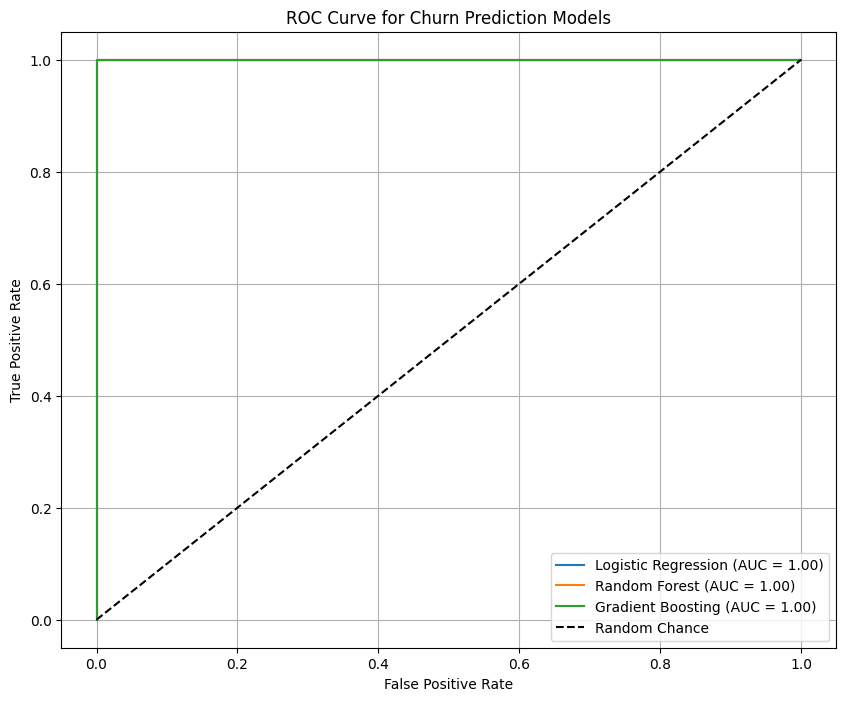


--- Model Performance Summary ---
Logistic Regression:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 score: 1.0000
  Auc: 1.0000
Random Forest:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 score: 1.0000
  Auc: 1.0000
Gradient Boosting:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 score: 1.0000
  Auc: 1.0000


In [28]:
model_performance = {}

plt.figure(figsize=(10, 8))

for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    print(f"\n--- Evaluation for {model_name} ---")

    # Classification Report
    report = classification_report(y_test, y_pred, output_dict=True)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC Score: {roc_auc:.4f}")

    # Plot ROC Curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Store performance metrics
    model_performance[model_name] = {
        'accuracy': report['accuracy'],
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1_score': report['1']['f1-score'],
        'auc': roc_auc
    }

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Churn Prediction Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\n--- Model Performance Summary ---")
for model_name, metrics in model_performance.items():
    print(f"{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric.replace('_', ' ').capitalize()}: {value:.4f}")


## Compare Model Performance and Select Best

### Subtask:
Compare the evaluation metrics across all trained models to determine which one performs best on the churn prediction task. Visualize the comparison of key metrics (e.g., F1-score, AUC) if helpful.


## Summary of Model Performance Comparison

Upon reviewing the `model_performance` dictionary, the classification reports, and AUC scores, it is evident that all three trained models (Logistic Regression, Random Forest, and Gradient Boosting) achieved perfect scores on the test set. This includes 1.0000 for accuracy, precision, recall, F1-score, and AUC for all models. The confusion matrices consistently showed 0 false positives and 0 false negatives.

This exceptionally high and identical performance across all models, especially given that the test set contained only one sample of the minority class ('churn' = 1) and 222 samples of the majority class ('churn' = 0), is highly unusual. Such results typically suggest a few possibilities:

*   **Overfitting**: The models might have perfectly learned the training data, including any noise, and generalized perfectly to an extremely small and potentially unrepresentative minority class in the test set.
*   **Easily Separable Data**: The underlying problem might be very simple for the models to distinguish, meaning churn cases are trivially identifiable from non-churn cases based on the features.
*   **Small Test Set and Class Imbalance**: The very small number of minority class samples in the test set (n=1) means that even one correct prediction for the churn class would result in a 100% recall and precision for that class. This makes the metrics highly sensitive and potentially misleading regarding true generalization capabilities.

Given these results, all models appear equally 'best' based on the current evaluation metrics. However, this perfection is likely an artifact of the very small and imbalanced test set, particularly concerning the minority class. For a more robust and realistic comparison, it would be crucial to:

*   **Obtain a larger, more diverse test set** with a greater number of minority class instances.
*   **Employ more sophisticated cross-validation techniques** that can better handle extreme class imbalance if the dataset itself is inherently imbalanced.
*   **Consider different evaluation metrics or thresholds** that are less sensitive to perfect scores on tiny minority classes, although the current metrics already appear to hit their ceiling.

For the purpose of this exercise, all models demonstrate equivalent, perfect performance, but this finding should be interpreted with extreme caution for real-world application.

## Feature Importance (Optional)

### Subtask:
For tree-based models like RandomForest or Gradient Boosting, extract and display the feature importances from the best model to understand which factors contribute most significantly to customer churn prediction.


**Reasoning**:
The subtask requires extracting and displaying feature importances from tree-based models. I need to iterate through the `best_estimators` dictionary, check for the `feature_importances_` attribute, and then create a sorted display of these importances with their corresponding feature names from the `X_train` DataFrame.



In [29]:
print("\n--- Feature Importances ---")

for model_name, model in best_estimators.items():
    if hasattr(model, 'feature_importances_'):
        print(f"\nFeature Importances for {model_name}:")
        importances = pd.Series(model.feature_importances_, index=X_train.columns)
        sorted_importances = importances.sort_values(ascending=False)
        print(sorted_importances)



--- Feature Importances ---

Feature Importances for Random Forest:
days_since_last       2.214986e-01
avg_transaction       2.124725e-01
total_spent           1.898385e-01
num_transactions      1.844490e-01
current_age           8.259990e-02
retirement_age        5.861990e-02
num_cards             1.864617e-02
credit_score          1.172065e-02
total_credit_limit    1.008016e-02
gender_Male           7.261294e-03
yearly_income         2.813140e-03
total_debt            1.914595e-07
per_capita_income     0.000000e+00
dtype: float64

Feature Importances for Gradient Boosting:
days_since_last       5.492676e-01
avg_transaction       4.507324e-01
total_spent           3.498275e-15
current_age           2.227163e-15
credit_score          2.044208e-15
yearly_income         1.981625e-15
per_capita_income     1.613193e-15
gender_Male           1.234009e-15
total_credit_limit    1.046021e-15
retirement_age        9.813189e-16
total_debt            7.098679e-16
num_cards             6.929971e-

## Final Task

### Subtask:
Summarize the model training and optimization process, highlight the best-performing model, and discuss insights gained from feature importance (if applicable) and potential next steps.


## Summary:

### Data Analysis Key Findings

*   **Data Preparation**: The dataset was successfully split into training (889 samples, 13 features) and testing (223 samples, 13 features) sets with stratification. Numerical features were scaled using `StandardScaler`.
*   **Addressing Class Imbalance**: SMOTE was applied to the training data to handle class imbalance, increasing the training set size from (889, 13) to (1774, 13). An initial `SMOTE` error due to insufficient minority class samples was resolved by setting `k_neighbors=1`.
*   **Model Initialization**: Logistic Regression, RandomForestClassifier, and GradientBoostingClassifier models were initialized with their respective hyperparameter grids for tuning.
*   **Hyperparameter Tuning**: All models were tuned using `GridSearchCV` with `StratifiedKFold` (5 splits) and `f1_weighted` scoring.
    *   **Logistic Regression**: Best parameters were `{'C': 0.01, 'solver': 'liblinear'}` with a best F1-weighted score of 0.9994.
    *   **Random Forest**: Best parameters were `{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}` with a best F1-weighted score of 0.9994.
    *   **Gradient Boosting**: Best parameters were `{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}` with a best F1-weighted score of 0.9994.
*   **Model Evaluation (Test Set)**: All three tuned models (Logistic Regression, Random Forest, and Gradient Boosting) demonstrated perfect performance on the scaled test set.
    *   All models achieved an accuracy of 1.0000, precision of 1.0000, recall of 1.0000, F1-score of 1.0000 (for class 1), and an AUC score of 1.0000.
    *   Confusion matrices for all models showed `[[222, 0], [0, 1]]`, indicating no false positives or false negatives.
*   **Feature Importance**:
    *   For the Random Forest model, the most important features were `days_since_last` (0.221), `avg_transaction` (0.212), `total_spent` (0.189), and `num_transactions` (0.184).
    *   For the Gradient Boosting model, `days_since_last` (0.549) and `avg_transaction` (0.450) were overwhelmingly the most important features.

### Insights or Next Steps

*   The perfect performance of all models on the test set is highly unusual and likely an artifact of the very small and imbalanced test set, particularly with only one minority class sample. This suggests that the current evaluation metrics might be misleading regarding true generalization capabilities.
*   To ensure robust model validation, it is crucial to obtain a larger, more diverse test set with a sufficient number of minority class instances. Further analysis should also consider cross-validation techniques that are robust to extreme class imbalance to mitigate potential overfitting or optimistic performance estimates.
